In [57]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/ccnlab/Development/dl4rl/')

import numpy as np
import pandas as pd
import tqdm

from sequence_generator import create_stim_sequence
from rl_models import PRL
from utils.simulate_utils import generate_valid_mappings
from concurrent.futures import ProcessPoolExecutor
from sim_agent import simulate_agent
import random
from utils.simulate_utils import generate_beta_with_diff_means_sim_vars


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
pval=1
num_blocks = 12

num_stimuli_list = [6, 6]
min_switches = [1200, 1200]
iter_per_stimuli = 13
num_actions = 3

all_seq = []
for i in range(num_blocks):
  all_seq.append(create_stim_sequence(iter_per_stimuli, num_stimuli_list[0]))


In [63]:
# Prepare the sequences

N_AGENTS = 3000
mean1 = 0.1
var = 0.01  # Variance of both distributions
phi_dist, _, _, _, _, _ = generate_beta_with_diff_means_sim_vars(mean1, 0.1, var, N_AGENTS, 0, 0.4)
# simulate N_AGENTS agents with randomly sampled alphas and betas

# Run simulations in parallel
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(simulate_agent, a, phi_dist, pval, num_blocks, num_stimuli_list, min_switches, iter_per_stimuli, num_actions, all_seq) for a in range(N_AGENTS)]
    train_data_list = [future.result() for future in tqdm.tqdm(futures)]

train_df = pd.concat(train_data_list)
train_df.head(3)

100%|██████████| 3000/3000 [00:28<00:00, 104.81it/s]


,agentid,actions,stimuli,correct_actions,rewards,trials,isswitch,iscorrectaction,alpha,beta,phi,rpe_history,unchosen_rpe_history,last_correct_trial,delay_since_last_correct,block_no,condition,set_size
0,0,2,0,0,0,0,0,0,0.319212,15.737489,0.055119,-0.333333,0.666667,NaN,0,0,1,6
1,0,0,1,2,0,1,0,0,0.319212,15.737489,0.055119,-0.333333,0.666667,NaN,0,0,1,6
2,0,2,2,1,0,2,0,0,0.319212,15.737489,0.055119,-0.333333,0.666667,NaN,0,0,1,6


In [ ]:
N_AGENTS = 500
mean1 = 0.1
var = 0.01  # Variance of both distributions
phi_dist, _, _, _, _, _ = generate_beta_with_diff_means_sim_vars(mean1, 0.1, var, N_AGENTS, 0, 0.4)
# simulate N_AGENTS agents with randomly sampled alphas and betas
train_data_list = []
for a in tqdm.tqdm(range(N_AGENTS)):
    rand_beta = random.uniform(0.2, 0.8)
    rand_alpha = random.uniform(0.2, 0.8) #random.choice([0.2, 0.8]) #
    rand_phi = phi_dist[a] #random.uniform(0, max_phi)
    agent = PRL(beta=rand_beta*20, pval=pval, id=a, phi=rand_phi)

    half_block_no = int(num_blocks/2)
    conditions = [0] * half_block_no + [1] * half_block_no
    random.shuffle(conditions)
    for block_no in range(num_blocks):
      cond = conditions[block_no]
      num_stimuli = num_stimuli_list[cond]
      min_switch = min_switches[cond]
      mappings = generate_valid_mappings(num_stimuli, num_actions)
      num_trials = num_stimuli*iter_per_stimuli

      agent.init_model(alpha=rand_alpha, stimuli=np.arange(num_stimuli), actions=np.arange(num_actions), mapping=mappings)
      
      data = agent.simulate_block(num_trials=num_trials, stimuli=all_seq[block_no], min_switch=min_switch)
      data['block_no'] = [block_no] * num_trials
      data['condition'] = [cond] * num_trials
      data['set_size'] = [num_stimuli] * num_trials
      train_data_list.append(data)

train_df = pd.concat(train_data_list)
train_df.head(3)

In [64]:
max_num_trials = train_df.trials.max()+1
filename = f"../data/rlf_6s3a/{N_AGENTS}a_{num_blocks}b_{max_num_trials}t_2ParamRL_no_switch_phi01_b20_seq.csv"
print(filename)
train_df.to_csv(filename)

../data/rlf_6s3a/3000a_12b_78t_2ParamRL_no_switch_phi01_b20_seq.csv


/var/folders/6y/khb9drcn0p373bwf72szrzvm0000gn/T/ipykernel_54555/1118997354.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.pointplot(
  0%|          | 0/500 [01:01<?, ?it/s]


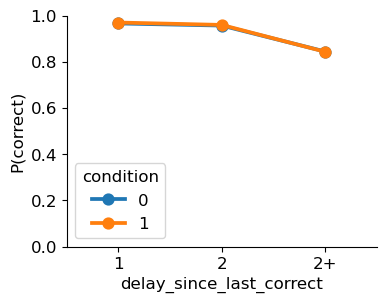

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

train_df['delay_since_last_correct_cat'] = train_df['delay_since_last_correct'].apply(lambda x: '2+' if x > 2 else str(x))
#train_df[['stimuli', 'trials', 'rewards', 'delay_since_last_correct']].tail(10)
res = train_df[train_df.delay_since_last_correct > 0]
res = (
    res.groupby(["agentid", "delay_since_last_correct_cat", "condition"])[["rewards"]]
    .mean()
    .reset_index()
)

plt.rcParams.update({"font.size": 12})
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=True)
ax = sns.pointplot(
    data=res,
    x="delay_since_last_correct_cat",
    y="rewards",
    order=['1', '2', '2+'],
    hue="condition",
    ax=ax,
    ci=95,
)
ax.set_xlabel("delay_since_last_correct")
ax.set_ylabel("P(correct)")
ax.set_yticks(np.round(np.arange(0, 1.2, 0.2), 2))

sns.despine()